<a href="https://colab.research.google.com/github/greyhound101/Brain_tumour/blob/master/lr_tune_3e_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Mounted at /content/gdrive


In [2]:
# import zipfile
# with zipfile.ZipFile('/content/gdrive/My Drive/archive.zip', 'r') as zip_ref:
#     zip_ref.extractall('')

In [3]:
pip install pydicom

In [4]:
import copy
from datetime import timedelta, datetime
import imageio
import matplotlib.pyplot as plt
from matplotlib import cm
import multiprocessing
import numpy as np
import os
from pathlib import Path
import pydicom
import pytest
import scipy.ndimage as ndimage
from scipy.ndimage.interpolation import zoom
from skimage import measure, morphology, segmentation
from time import time, sleep
from tqdm import trange, tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DistributedSampler, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import warnings

In [5]:
class CTTensorsDataset(Dataset):
    def __init__(self, transform=None):
        self.tensor_files = [Path(i) for i in glob.glob('/content/ID*')]
        self.transform = transform

    def __len__(self):
        return len(self.tensor_files)

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.tolist()

        image = torch.load(self.tensor_files[item])
        if self.transform:
            image = self.transform(image)

        return {
            'patient_id': self.tensor_files[item].stem,
            'image': image
        }

    def mean(self):
        cum = 0
        for i in range(len(self)):
            sample = self[i]['image']
            cum += torch.mean(sample).item()

        return cum / len(self)

    def random_split(self, val_size: float):
        num_val = int(val_size * len(self))
        num_train = len(self) - num_val
        return random_split(self, [num_train, num_val])

In [6]:
class ZeroCenter:
    def __init__(self, pre_calculated_mean):
        self.pre_calculated_mean = pre_calculated_mean

    def __call__(self, tensor):
        return tensor - self.pre_calculated_mean

In [7]:
root_dir = '/kaggle/input/osic-cached-dataset'
test_dir = '/kaggle/input/osic-pulmonary-fibrosis-progression/test'
model_file = '/kaggle/working/diophantus.pt'
resize_dims = (40, 256, 256)
clip_bounds = (-1000, 200)
watershed_iterations = 1
pre_calculated_mean = 0.02865046213070556
latent_features = 10
batch_size = 16
learning_rate = 3e-4
num_epochs = 10
val_size = 0.2
tensorboard_dir = '/kaggle/working/runs'

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
import glob
train = CTTensorsDataset(
    transform=ZeroCenter(pre_calculated_mean=pre_calculated_mean)
)
# cum = 0
# for i in range(len(train)):
#     sample = train[i]['image']
#     cum += torch.mean(sample).item()

# assert cum / len(train) == pytest.approx(0)

In [9]:
class VarAutoEncoder(nn.Module):
    def __init__(self, latent_features=latent_features):
        super(VarAutoEncoder, self).__init__()
        # Encoder
        self.conv1 = nn.Conv3d(1, 16, 3)
        self.conv2 = nn.Conv3d(16, 32, 3)
        self.conv3 = nn.Conv3d(32, 96, 2)
        self.conv4 = nn.Conv3d(96, 1, 1)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        self.pool2 = nn.MaxPool3d(kernel_size=3, stride=3, return_indices=True)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        self.pool4 = nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        self.fc1 = nn.Linear(10 * 10, latent_features)
        self.fc2 = nn.Linear(10 * 10, latent_features)
        self.act=nn.LeakyReLU(0.1)
        # Decoder
        self.fc3 = nn.Linear(latent_features, 10 * 10)
        self.deconv0 = nn.ConvTranspose3d(1, 96, 1)
        self.deconv1 = nn.ConvTranspose3d(96, 32, 2)
        self.deconv2 = nn.ConvTranspose3d(32, 16, 3)
        self.deconv3 = nn.ConvTranspose3d(16, 1, 3)
        self.unpool0 = nn.MaxUnpool3d(kernel_size=2, stride=2)
        self.unpool1 = nn.MaxUnpool3d(kernel_size=2, stride=2)
        self.unpool2 = nn.MaxUnpool3d(kernel_size=3, stride=3)
        self.unpool3 = nn.MaxUnpool3d(kernel_size=2, stride=2)

    def encode(self, x, return_partials=True):
        # Encoder
        x = self.act(self.conv1(x))
        up3out_shape = x.shape
        x, i1 = self.pool1(x)

        x = self.act(self.conv2(x))
        up2out_shape = x.shape
        x, i2 = self.pool2(x)

        x = self.act(self.conv3(x))
        up1out_shape = x.shape
        x, i3 = self.pool3(x)

        x = self.act(self.conv4(x))
        up0out_shape = x.shape
        x, i4 = self.pool4(x)

        x = x.view(-1, 10 * 10)
        
        mu = self.act(self.fc1(x))
        log_var = self.act(self.fc2(x))
        
        if return_partials:
            
            return mu, log_var, up3out_shape, i1, up2out_shape, i2, up1out_shape, i3, \
                   up0out_shape, i4

        else:
            return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        mu, log_var, up3out_shape, i1, up2out_shape, i2, \
        up1out_shape, i3, up0out_shape, i4 = self.encode(x)
        
        z = self.reparameterize(mu, log_var)
       
        # Decoder
        x = F.relu(self.fc3(z))
        x = x.view(-1, 1, 1, 10, 10)
        x = self.unpool0(x, output_size=up0out_shape, indices=i4)
        x = self.act(self.deconv0(x))
        x = self.unpool1(x, output_size=up1out_shape, indices=i3)
        x = self.act(self.deconv1(x))
        x = self.unpool2(x, output_size=up2out_shape, indices=i2)
        x = self.act(self.deconv2(x))
        x = self.unpool3(x, output_size=up3out_shape, indices=i1)
        x = self.act((self.deconv3(x)))

        return x, mu, log_var

In [10]:
t0 = time()

# Load the data
data = CTTensorsDataset(
    transform=ZeroCenter(pre_calculated_mean=pre_calculated_mean)
)
train_set, val_set = data.random_split(val_size)
datasets = {'train': train_set, 'val': val_set}
dataloaders = {
    x: DataLoader(
        datasets[x],
        batch_size=batch_size,
        shuffle=(x == 'train'),
        num_workers=2
    ) for x in ['train', 'val']}

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}

# Prepare for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = VarAutoEncoder(latent_features=latent_features).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
best_model_wts = None
best_loss = np.inf

date_time = datetime.now().strftime("%Y%m%d-%H%M")
log_dir = Path(tensorboard_dir) / f'{date_time}'
writer = SummaryWriter(log_dir)

In [11]:
total_loss=  {'train':[],'val':[]}
for epoch in range(100):

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_preds = 0

        # Iterate over data.
        bar = tqdm(dataloaders[phase])
        for inputs in bar:
            bar.set_description(f'Epoch {epoch + 1} {phase}'.ljust(20))
            inputs = inputs['image'].to(device, dtype=torch.float)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs, mu, log_var = model(inputs)
                
                # For KL divergence, see Appendix B in VAE paper or http://yunjey47.tistory.com/43
                reconst_loss = F.mse_loss(outputs, inputs, size_average=False)
                kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
                
                loss =  reconst_loss + kl_div

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_preds += inputs.size(0)
            bar.set_postfix(loss=f'{running_loss / running_preds:0.6f}')
        total_loss[phase].append(loss.item()  )
        epoch_loss = running_loss / dataset_sizes[phase]
        writer.add_scalar(f'Loss/{phase}', epoch_loss, epoch)

        # deep copy the model
        if phase == 'val' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, model_file)

# load best model weights
model.load_state_dict(best_model_wts)

print(f'Done! Time {timedelta(seconds=time() - t0)}')

Epoch 1 train       :   0%|          | 0/9 [00:05<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Epoch 100 val       : 100%|██████████| 3/3 [00:03<00:00,  1.10s/it, loss=220795.663728]

Done! Time 0:51:46.109964


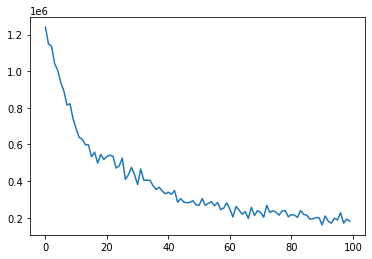

In [12]:
import seaborn as sns
sns.lineplot(y=total_loss['train'],x=list(range(len(total_loss['train']))))

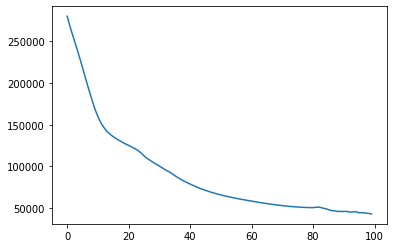

In [13]:
sns.lineplot(y=total_loss['val'],x=list(range(len(total_loss['val']))))